In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

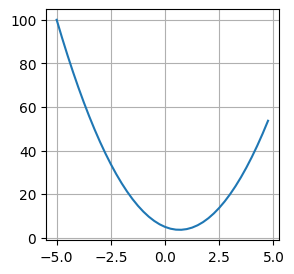

In [3]:
xs = np.arange(-5, 5, 0.25)
y = f(xs)
plt.figure(figsize=(3,3))
plt.plot(xs, y)
plt.grid(True)

In [4]:
# derivative
h = 0.001
x = 3
(f(x + h) - f(x))/h

14.00300000000243

In [24]:
h = 0.001
a = 2
b = -3
c = 10

d1 = a * b + c
c += h
d2 = a * b + c
print("slope:", (d2-d1)/h)

slope: 0.9999999999994458


## Micrograd Scratch

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [234]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
#     assert rankdir in ['LR', 'TB']
#     nodes, edges = trace(root)
    dot = Digraph(format="svg", graph_attr={'rankdir': "LR"}) #, node_attr={'rankdir': 'TB'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | Data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


In [169]:
def manual_grad():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    d.data = d.data+h
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data
    
    return (L2-L1)/h

In [385]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only int and floats are Valid"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
        
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out
    
    def tanh(self):
        exp = math.exp(2*self.data)
        t = (exp - 1)/(exp + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += out.grad * (1 - (t**2))
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo_ls = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo_ls.append(v)
                
        topological_sort(self)
        
        self.grad = 1.0
        for node in reversed(topo_ls):
            node._backward()
        

In [235]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a * b; c.label='c'
d = Value(3.0, label='d')
e = c * d; e.label='e'

In [236]:
e.backward()

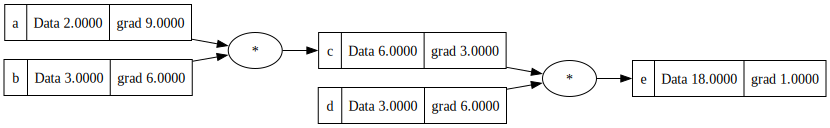

In [237]:
draw_dot(e)

In [386]:
x1 = Value(2, label='x1')
w1 = Value(-3, label='w1')
x2 = Value(0, label='x2')
w2 = Value(1, label='w2')

x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
b = Value(6.8813735870195432, label='b')
n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

o.backward()

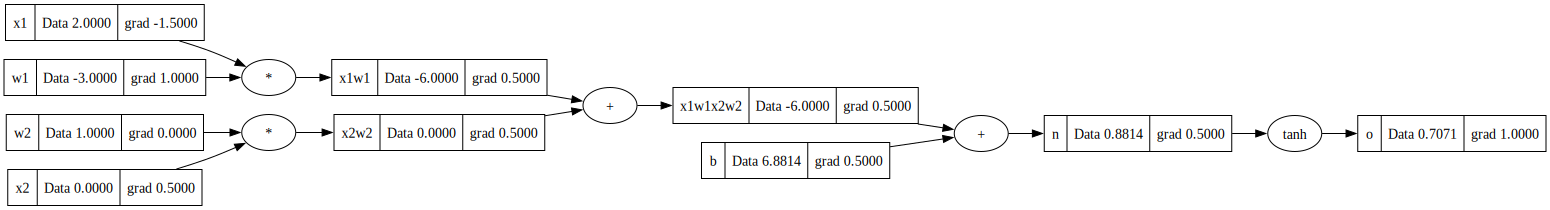

In [387]:
draw_dot(o)

In [390]:
# Same thing but using PyTorch
import torch

a = torch.tensor([2.0])  ; a.requires_grad=True
b = torch.tensor([3.0])  ; b.requires_grad=True
c = a * b;
d = torch.tensor([3.0])  ; d.requires_grad=True
e = c * d; 
e.backward()

f"a:{a.grad}, b:{b.grad}, d:{d.grad}"

'a:tensor([9.]), b:tensor([6.]), d:tensor([6.])'